In [200]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from kalman_filter_process import f_x, y_x
import numpy as np
import pandas as pd
import pylab
import random
from scipy.stats import describe

### Functions $f(x)$ and $y(x)$ from the paper

In [201]:
def f_x(state, dt):
    # constant for sampling time
    h = 2
    
    I_eff = state[0]
    G_s = state[1]
    R_a = state[2]
    R_a_neg_1 = state[3]
    p_1 = state[4]
    p_2 = state[5]
    p_4 = state[6]
    tau = state[7]

    # other required variables not part of the state
    w_k = np.random.normal(1)

    I_p = 0 + w_k
    C = 0 + w_k
    p_3 = 0 + w_k
    V = 0 + w_k # todo check for nonzero for V and value as 140

    # compute I_eff(k+1)
    component_1 = h * (p_2 * (I_eff/(h * p_2) - I_eff))
    component_2 = p_3 * I_p
    I_eff_next = component_1 + component_2

    # compute R_a(k+1)
    a = np.exp((h/tau))
    component_1 = (h * C) / (V * a * tau)
    component_2 = (2 * R_a) / a
    component_3 = R_a_neg_1 / a ** 2
    R_a_next = component_1 + component_2 - component_3

    # assuming G_b to be static for now have asked the prof whether this is fine.
    # todo otherwise the transition function will be time-dependent and that's way harder to implement.
    G_b = 100

    # computing G_s(k+1)
    component_1 = p_1 * (G_b + (G_s / (h * p_1)) - G_s)
    component_2 = p_2 * I_eff * G_s
    component_3 = R_a
    G_s_next = h * (component_1 - component_2 + component_3)

    # remaining variables for the next state
    R_a_neg_1_next = R_a
    p_1_next = p_1
    p_2_next = p_2
    p_4_next = p_4
    tau_next = tau

    next_state = [
        I_eff_next,
        G_s_next,
        R_a_next,
        R_a_neg_1_next,
        p_1_next,
        p_2_next,
        p_4_next,
        tau_next
    ]
    return next_state


def y_x(state):
    # the observation function takes the state and returns the CGM value only because that's what we
    # actually measure
    G_s = state[1]
    return np.array([G_s])

### Read in the meal data

In [237]:
cgm_to_meal = pd.read_csv('data/cgm_to_meal_start.csv')
cgm_to_meal = cgm_to_meal.dropna()
cgm = cgm_to_meal['cgm'].to_numpy()

In [223]:
print(cgm)

[314. 314. 314. ... 118. 118. 118.]


### Get the training points

In [226]:
TRAIN_POINTS = 500
START_INDEX = 1249
train = cgm[START_INDEX:START_INDEX + TRAIN_POINTS]

### Prepare Kalman Filter inputs

In [227]:
dt = 0.1 # time between samples
points = MerweScaledSigmaPoints(8, alpha=1, beta=2, kappa=0) # sigma points
kf = UnscentedKalmanFilter(dim_x=8, dim_z=1, dt=dt, fx=f_x, hx=y_x, points=points)

# remaining inputs are taken directly from the paper
kf.x = np.array([0, cgm[0], 0, 0, 0.068, 0.037, 1.3, 20]) 
kf.R = np.array([100])
kf.Q = np.diag([1e-06, 1e-06, 1e-03, 1e-03, 1e-02, 1e-01, 1e-02, 1e-01])

### Run the kalman filter predict and update loop, and output predictions at every step

In [228]:
compare = []
for y in train[1:]:
    kf.predict()
    compare.append((kf.x[1], y))
    kf.update(y)
compare = np.array(compare)

### Predicted CGM vs measured CGM values

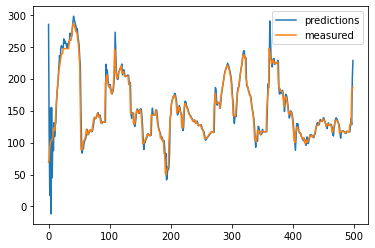

In [229]:
predictions = compare[:, 0]
measured = compare[:, 1]
pylab.plot(predictions, label='predictions')
pylab.plot(measured, label='measured')
pylab.legend()

# Thresholding

In [15]:
labels = cgm_to_meal['meal'].values[START_INDEX:START_INDEX + TRAIN_POINTS]


499


In [248]:

meal_start_indices = cgm_to_meal.loc[cgm_to_meal['meal_start']==1].index.tolist()
meal_30_indices = cgm_to_meal.loc[cgm_to_meal['meal']==1].index.tolist()
meal_indices = np.concatenate((meal_start_indices,meal_30_indices),axis=0).tolist()

non_meal_indices = cgm_to_meal.loc[(cgm_to_meal['meal']==0) & (cgm_to_meal['meal_start']==0) ].index.tolist()
# non_meal_30_indices = cgm_to_meal.loc[cgm_to_meal['meal_start']==0].index.tolist()
# non_meal_indices = np.concatenate((non_meal_start_indices,non_meal_30_indices),axis=0).tolist()

NUM_POINTS_MEAL = 800
NUM_POINTS_NON_MEAL = 1500

meal_indices_random = random.sample(meal_indices, NUM_POINTS_MEAL)
non_meal_indices_random = random.sample(non_meal_indices, NUM_POINTS_NON_MEAL)
D = [(meal_indices_random,'1'),(non_meal_indices_random,'0')]

prediction_array_meal = []
prediction_array_non_meal = []

for d in D:
    print(d[1])
    if d[1] == '1':
        NUM_POINTS = NUM_POINTS_MEAL
    else:
        NUM_POINTS = NUM_POINTS_NON_MEAL
        
    for idx in d[0]:
        if(idx >= NUM_POINTS):
            startIndex = idx - NUM_POINTS
            non_meal_points = cgm_to_meal.loc[cgm_to_meal['meal']==0]
            non_meal_points = non_meal_points.loc[startIndex:idx].index
            train = cgm_to_meal['cgm'].loc[non_meal_points]
        else:
            startIndex = 0
            non_meal_points = cgm_to_meal.loc[cgm_to_meal['meal']==0]
            non_meal_points = non_meal_points.loc[startIndex:idx].index
            train = cgm_to_meal['cgm'].loc[non_meal_points]
            
        dt = 0.1 # time between samples
        points = MerweScaledSigmaPoints(8, alpha=1, beta=2, kappa=0) # sigma points
        kf = UnscentedKalmanFilter(dim_x=8, dim_z=1, dt=dt, fx=f_x, hx=y_x, points=points)

        # remaining inputs are taken directly from the paper
        kf.x = np.array([0, cgm[0], 0, 0, 0.068, 0.037, 1.3, 20]) 
        kf.R = np.array([100])
        kf.Q = np.diag([1e-06, 1e-06, 1e-03, 1e-03, 1e-02, 1e-01, 1e-02, 1e-01])

        compare = []
        for y in train[1:]:
            try:
                kf.predict()
                compare.append((kf.x[1], y))
                kf.update(y)
            except Exception:
                pass
        compare = np.array(compare)
        try:
            kf.predict()
            meal_prediction = kf.x[1]
        except Exception:
            pass
    
        
        if(d[1] == '1'):
            prediction_array_meal.append((meal_prediction,cgm_to_meal['cgm'].loc[idx]))
        else:
            prediction_array_non_meal.append((meal_prediction,cgm_to_meal['cgm'].loc[idx]))



1


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filter

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/pytho

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: Ru

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: inv

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-p

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/li

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountere

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid valu

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/pyth

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning:

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divid

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overf

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/pyth

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in doub

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning:

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in doub

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtr

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/pytho

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in 

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/

0


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scala

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/ana

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykern

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_tran

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/o

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/pytho

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divid

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overfl

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-proje

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filter

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/op

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/ana

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/pytho

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/pyth

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_sc

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/pyth

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/pyth

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in doub

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scala

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/pyth

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/pyth

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, 

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-fi

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/pytho

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overfl

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning:

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divid

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encount

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - do

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anacon

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: inva

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/ana

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWar

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/sigma_points.py:168: RuntimeWarning: overflow encountered in multiply
  U = self.sqrt((lambda_ + n)*P)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/pyth

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_sc

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/unscented_transform.py:117: RuntimeWarning: invalid value encountered in subtract
  y = sigmas - x[np.newaxis, :]
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:484: RuntimeWarning: invalid value encountered in add
  Pxz += self.Wc[i] * outer(dx, dz)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:482: RuntimeWarning: invalid value encountered in subtract
  dx = self.residual_x(sigmas_f[i], x)
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/envs

/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))
/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/filterpy/kalman/UKF.py:462: RuntimeWarning: invalid value encountered in subtract
  self.P = self.P - dot(self.K, dot(self.S, self.K.T))


[284.896      147.68953865 408.29810439 -76.91842605 619.16519643
 -10.23892228 330.15502284  19.59918977 135.74118579  66.07392004
  62.91564667  55.99975004  55.468367    66.23639458  47.03884749
  53.83189153  51.76589107  78.6274525   54.88383086  68.42661983
  49.99674627  62.03607573  61.44200405  51.15692168  53.54595583
  81.84731824  39.91594268 117.82994755  73.58552322 116.24688202
  96.62825686 112.00869641 130.46132087 159.5778022  141.50743946
 151.34093494 149.45757555 149.81933091 143.74572248 146.79495999
 113.29483294 125.85923332  81.10517296  94.67048151  89.22348757
  95.74647025  91.76799533  93.22935207 116.75628884 105.69109847
  86.31451178  92.2231728   90.12036856 172.41982751 127.39915057
 139.08534833 218.48648299 175.12313401 183.90408715 179.98701778
 179.16441736 179.6914729  312.81287225 241.57332254 250.49739244
 247.26928137 246.25617719 318.60454686 284.05044847 282.30393953
 284.91794425 300.09460387 292.40909832 298.63111801 295.56263505
 310.45857

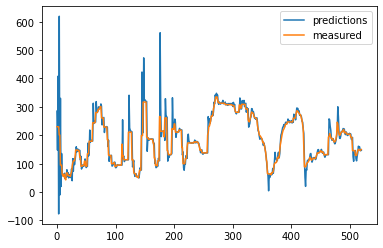

In [249]:
predictions = compare[:, 0]
measured = compare[:, 1]
pylab.plot(predictions[:-1], label='predictions')
pylab.plot(measured[:-1], label='measured')
pylab.legend()
print(predictions)

In [250]:
prediction_array_meal = [(x[0],x[1]) for x in prediction_array_meal if (x[0]<1000 and x[0]>0)]
prediction_array_non_meal = [(x[0],x[1]) for x in prediction_array_non_meal if (x[0]<1000 and x[0]>0)]
prediction_array_meal = np.array(prediction_array_meal)
prediction_array_non_meal = np.array(prediction_array_non_meal)
print(len(prediction_array_meal),np.mean(prediction_array_meal[:,0]))
print(len(prediction_array_non_meal),np.mean(prediction_array_non_meal[:,0]))

800 98.757028080831
1500 114.05967981037651


In [251]:
prediction_array_non_meal.tolist()

[[175.64110399954836, 106.0],
 [175.64110399954836, 205.0],
 [175.64110399954836, 95.0],
 [175.64110399954836, 159.0],
 [175.64110399954836, 158.0],
 [175.64110399954836, 113.0],
 [175.64110399954836, 205.0],
 [175.64110399954836, 214.0],
 [175.64110399954836, 136.0],
 [175.64110399954836, 102.0],
 [175.64110399954836, 191.0],
 [175.64110399954836, 113.0],
 [175.64110399954836, 140.0],
 [175.64110399954836, 134.0],
 [175.64110399954836, 130.0],
 [175.64110399954836, 170.0],
 [175.64110399954836, 117.0],
 [175.64110399954836, 106.0],
 [175.64110399954836, 146.0],
 [175.64110399954836, 218.0],
 [175.64110399954836, 140.0],
 [175.64110399954836, 126.0],
 [175.64110399954836, 116.0],
 [175.64110399954836, 195.0],
 [175.64110399954836, 209.0],
 [175.64110399954836, 178.0],
 [175.64110399954836, 61.0],
 [175.64110399954836, 205.0],
 [175.64110399954836, 253.0],
 [175.64110399954836, 111.0],
 [175.64110399954836, 135.0],
 [175.64110399954836, 161.0],
 [175.64110399954836, 147.0],
 [175.641103

In [252]:
residual_meal = []
for i in range(len(prediction_array_meal)):
    residual_meal.append(np.abs(prediction_array_meal[i][1]-prediction_array_meal[i][0]))
# residual_meal = np.array(residual_meal)
# meal_residual_mean = np.mean(residual_meal)

residual_non_meal = []
for i in range(len(prediction_array_non_meal)):
    residual_non_meal.append(np.abs(prediction_array_non_meal[i][1]-prediction_array_non_meal[i][0]))
# residual_non_meal = np.array(residual_non_meal)
# meal_residual_non_mean = np.mean(residual_non_meal)



In [253]:
describe(residual_meal)


DescribeResult(nobs=800, minmax=(0.03660602478282726, 312.71281576305734), mean=80.2659585060684, variance=4144.446010033005, skewness=1.0633113813672057, kurtosis=0.7504706126094143)

In [254]:
describe(residual_non_meal)

DescribeResult(nobs=1500, minmax=(0.0051012816516333714, 321.3699131197719), mean=82.2448383283469, variance=3682.3772917116175, skewness=0.9407534214343134, kurtosis=0.6530227756070346)

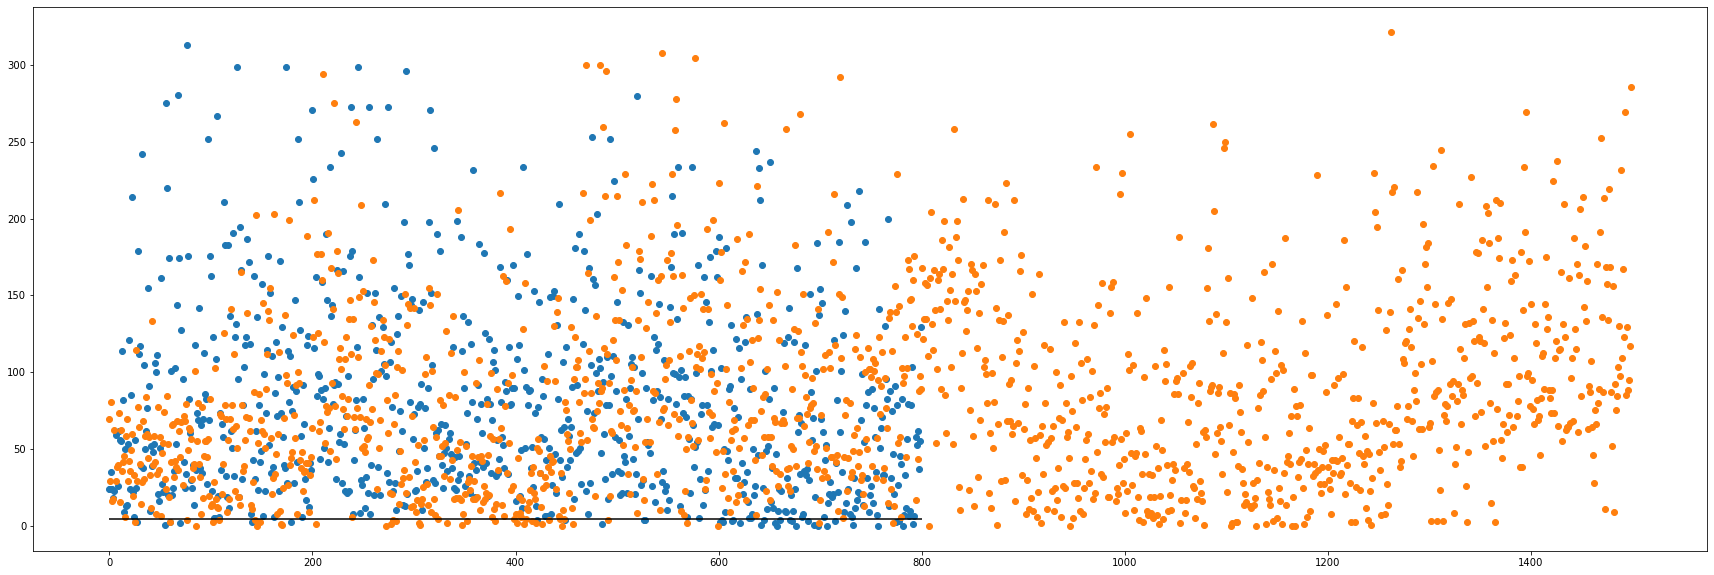

In [256]:
import matplotlib.pyplot as plt
x_meal = np.arange(0,len(residual_meal))
y_meal = np.array(residual_meal)
x_non_meal = np.arange(0,len(residual_non_meal))
y_non_meal = np.array(residual_non_meal)
plt.figure(figsize=(30, 10))
plt.scatter(x_meal,y_meal)
plt.scatter(x_non_meal,y_non_meal)
plt.hlines(4.5, 0, 800, color='black')

In [257]:
non_meal_diff = np.array(residual_non_meal)
meal_diff = np.array(residual_meal)

In [265]:
threshold = 100
non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]
print("Non meal predicted correctly: ", non_meal_row[0])
print("Non meal predicted wrongly: ", non_meal_row[1])
print("Meal predicted correctly: ", meal_row[1])
print("Meal predicted wrongly: ", meal_row[0])

print("accuracy",  (non_meal_row[0] + meal_row[1]) / (non_meal_row[0] + meal_row[1] + non_meal_row[1] + meal_row[0]) )

Non meal predicted correctly:  1010
Non meal predicted wrongly:  490
Meal predicted correctly:  248
Meal predicted wrongly:  552
accuracy 0.5469565217391305
